# Downloading & Exploring Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import seaborn as sns

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

import cv2
import torch
import torch.optim
from albumentations.pytorch import ToTensorV2
from torch import nn

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("titan15555/uavid-semantic-segmentation-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.69G/3.69G [00:47<00:00, 82.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1


In [ ]:
!ls $path

test  train  valid


In [ ]:
!ls $path/train/train

seq1   seq11  seq13  seq15  seq3   seq32  seq34  seq4  seq6  seq8
seq10  seq12  seq14  seq2   seq31  seq33  seq35  seq5  seq7  seq9


In [ ]:
!ls $path/train/train/seq1

Images	Labels


In [ ]:
!ls $path/train/train/seq1/Images

000000.png  000200.png	000400.png  000600.png	000800.png
000100.png  000300.png	000500.png  000700.png	000900.png


In [3]:
train_dir = os.path.join(path, 'train', 'train')
test_dir = os.path.join(path, 'test', 'test')
val_dir = os.path.join(path, 'valid', 'valid')

print(len(os.listdir(train_dir)), len(os.listdir(test_dir)), len(os.listdir(val_dir)))

20 1 7


# EDA & Data Distributions

In [ ]:
# The number of whole images in each subset

not_image_files = []
for subset in [train_dir, test_dir, val_dir]:
    print(f'Exploring {subset}:')
    samples = dict()
    for seq in os.listdir(subset):
        seq_dir_images = os.path.join(subset, seq, 'Images')
        samples[seq] = []
        for files in os.listdir(seq_dir_images):
            if files.endswith('.jpg') or files.endswith('.png'):
                samples[seq].append(files)
            else:
                not_image_files.append(files)
    print(f'Number of sequences: {len(samples.keys())}')
    count = 0
    for seq_len in [len(samples[seq]) for seq in samples.keys()]:
        count+=seq_len
    print(f'Number of images: {count}')
    print([len(samples[seq]) for seq in samples.keys()])
    print('-----------------------------------------------------')

Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/train/train:
Number of sequences: 20
Number of images: 200
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
-----------------------------------------------------
Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/test/test:
Number of sequences: 1
Number of images: 10
[10]
-----------------------------------------------------
Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/valid/valid:
Number of sequences: 7
Number of images: 70
[10, 10, 10, 10, 10, 10, 10]
-----------------------------------------------------


In [ ]:
len(not_image_files)

0

In [ ]:
# Exploring labels

not_label_files = []
for subset in [train_dir, val_dir]:
    print(f'Exploring {subset}:')
    samples = dict()
    unique_labels = set() # Initialize as a set to collect unique values efficiently
    shapes = set()
    for seq in os.listdir(subset):
        seq_dir_labels = os.path.join(subset, seq, 'Labels')
        samples[seq] = []
        for files in os.listdir(seq_dir_labels):
            if files.endswith('.jpg') or files.endswith('.png'):
                label_path = os.path.join(seq_dir_labels, files)
                samples[seq].append(label_path)
                label = PIL.Image.open(label_path)
                label_array = np.array(label)
                shapes.add(label_array.shape)
                unique_labels.update(np.unique(label_array)) # Use update to add unique elements to the set
            else:
                not_label_files.append(files)
    print(f'Number of sequences: {len(samples.keys())}')
    count = 0
    for seq_len in [len(samples[seq]) for seq in samples.keys()]:
        count+=seq_len
    print(f'Number of labels: {count}')
    print([len(samples[seq]) for seq in samples.keys()])
    print(f'Unique labels: {np.sort(list(unique_labels))}') # Convert set to a sorted list for printing
    print(f'Unique shapes: {shapes}')
    print('-----------------------------------------------------')

Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/train/train:
Number of sequences: 20
Number of labels: 200
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Unique labels: [  0  64 128 192]
Unique shapes: {(2160, 3840, 3), (2160, 4096, 3)}
-----------------------------------------------------
Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/valid/valid:
Number of sequences: 7
Number of labels: 70
[10, 10, 10, 10, 10, 10, 10]
Unique labels: [  0  64 128 192]
Unique shapes: {(2160, 3840, 3), (2160, 4096, 3)}
-----------------------------------------------------


In [ ]:
np.unique(label_array)

array([  0,  64, 128, 192], dtype=uint8)

In [ ]:
label_array.shape

(2160, 3840, 3)

In [ ]:
label_array

array([[[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]]

000000.png


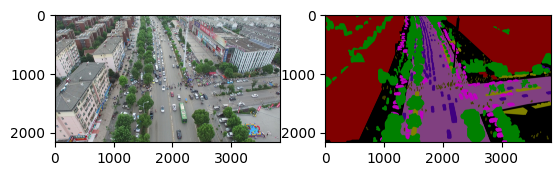

Unique labels: [  0  64 128 192]
********************
000100.png


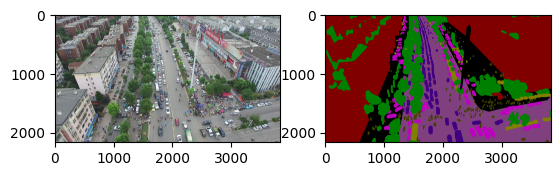

Unique labels: [  0  64 128 192]
********************
000800.png


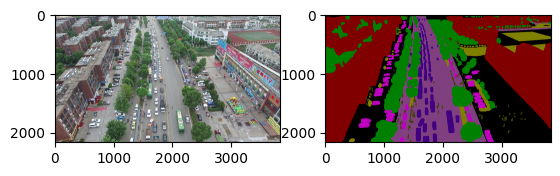

Unique labels: [  0  64 128 192]
********************
000900.png


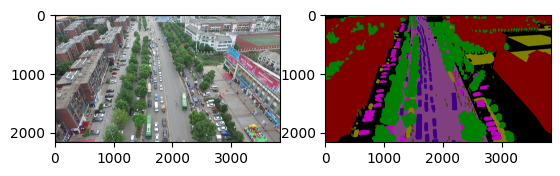

Unique labels: [  0  64 128 192]
********************
000500.png


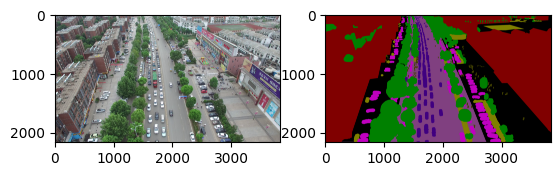

Unique labels: [  0  64 128 192]
********************
000100.png


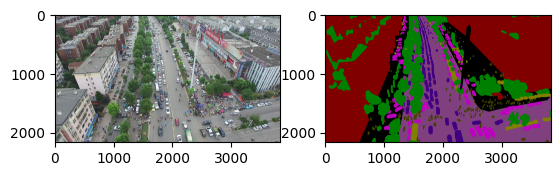

Unique labels: [  0  64 128 192]
********************
000800.png


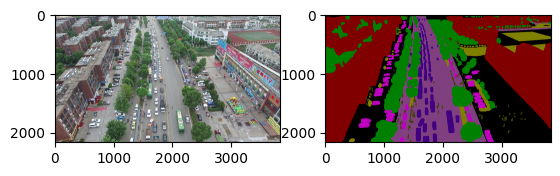

Unique labels: [  0  64 128 192]
********************
000800.png


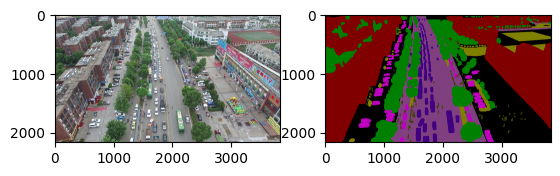

Unique labels: [  0  64 128 192]
********************
000500.png


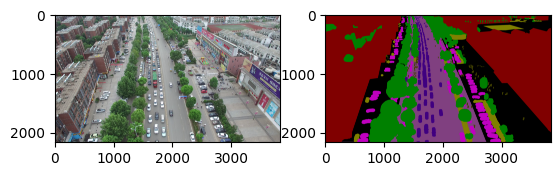

Unique labels: [  0  64 128 192]
********************
000700.png


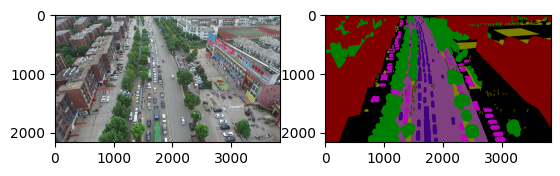

Unique labels: [  0  64 128 192]
********************


In [ ]:
# Visualize some samples
import random

val_labels = [el for key in samples.keys() for el in samples[key]]

sample = random.sample(val_labels, 10)

for label_path in sample:
    print(label_path.split('/')[-1])
    label = PIL.Image.open(label_path)
    label_array = np.array(label)

    img_path = label_path.replace('Labels', 'Images')
    img = PIL.Image.open(img_path)

    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(label)
    plt.show()
    print(f'Unique labels: {np.unique(label_array)}')
    print(20*'*')


In [ ]:
unique_colors = np.unique(label_array.reshape(-1, label_array.shape[2]), axis=0)
print(f"Number of unique colors: {len(unique_colors)}")
print(f"Unique colors:\n{unique_colors}")

Number of unique colors: 8
Unique colors:
[[  0   0   0]
 [  0 128   0]
 [ 64   0 128]
 [ 64  64   0]
 [128   0   0]
 [128  64 128]
 [128 128   0]
 [192   0 192]]


**Explanation:** <br>
* label_array: This is your original NumPy array representing the image (or label mask). For a color image, its shape is typically (height, width, 3), where 3 corresponds to the Red, Green, and Blue color channels.

* label_array.shape[2]: This part simply retrieves the size of the third dimension of your label_array. In our case, for an RGB image, this will be 3 (representing the R, G, and B components of each pixel).

* label_array.reshape(-1, label_array.shape[2]): This is a crucial step.

  1.  reshape() is a NumPy function that changes the dimensions (shape) of an array without changing its data.

  2. We use -1 in the first dimension argument. When you use -1, NumPy automatically calculates the size of that dimension based on the total number of elements in the array and the size of the other specified dimensions. In this case, it effectively flattens the height and width dimensions into a single dimension.

  3. The second dimension argument is label_array.shape[2], which we determined to be 3. This means we are reshaping the array into a 2D array where each 'row' has 3 columns. Each of these 'rows' now represents a single pixel's RGB color triplet [R, G, B].

  4. Example: If your label_array was (2160, 3840, 3), reshaping it with (-1, 3) turns it into an array of shape (2160 * 3840, 3). So, you get a long list of individual pixels, each represented by its [R, G, B] values.

* np.unique(..., axis=0): Finally, we apply np.unique() to this reshaped array.

  1. By default, np.unique() would find all unique scalar values in the entire array (e.g., it would return [0, 64, 128, 192] as unique individual numbers, not unique color combinations).
  2. However, by adding axis=0, we tell np.unique() to look for unique rows. Since each row in our reshaped array is an [R, G, B] color triplet, np.unique(..., axis=0) effectively finds all the unique [R, G, B] color combinations present in your image.

# Preprocessing Labels: RGB to Class ID Mask

To prepare the labels for a semantic segmentation model, we need to convert the 3-channel RGB images into single-channel masks where each pixel's value is an integer representing its class. We will use the `unique_colors` identified previously to create a mapping.

## Gemini Version

In [ ]:
# Assuming 'unique_colors' is available from the previous execution
# If not, it can be re-run or defined manually based on the output:
# unique_colors = np.array(
#     [[  0,   0,   0],
#      [  0, 128,   0],
#      [ 64,   0, 128],
#      [ 64  64   0],
#      [128   0   0],
#      [128  64 128],
#      [128 128   0],
#      [192   0 192]], dtype=np.uint8)

# Create a mapping from RGB tuple to class ID
color_to_class_map = {tuple(color): i for i, color in enumerate(unique_colors)}

print("RGB to Class ID Map:")
for color, class_id in color_to_class_map.items():
    print(f"  {color} -> {class_id}")

RGB to Class ID Map:
  (np.uint8(0), np.uint8(0), np.uint8(0)) -> 0
  (np.uint8(0), np.uint8(128), np.uint8(0)) -> 1
  (np.uint8(64), np.uint8(0), np.uint8(128)) -> 2
  (np.uint8(64), np.uint8(64), np.uint8(0)) -> 3
  (np.uint8(128), np.uint8(0), np.uint8(0)) -> 4
  (np.uint8(128), np.uint8(64), np.uint8(128)) -> 5
  (np.uint8(128), np.uint8(128), np.uint8(0)) -> 6
  (np.uint8(192), np.uint8(0), np.uint8(192)) -> 7


Original label_array shape: (2160, 3840, 3)
Converted mask shape: (2160, 3840)
Unique class IDs in the example mask: [0 1 2 3 4 5 6 7]


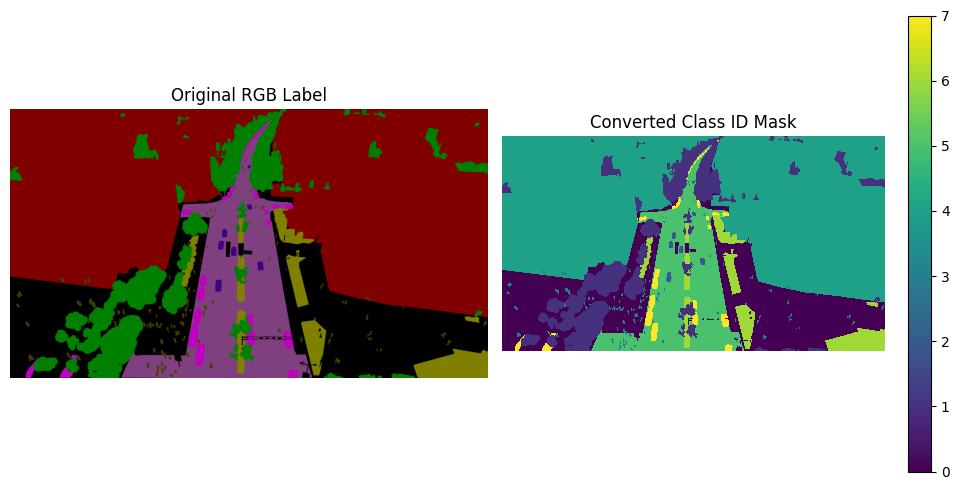

In [ ]:
def rgb_to_mask(rgb_label_image, color_map):
    """
    Converts a 3-channel RGB label image to a single-channel class ID mask.

    Args:
        rgb_label_image (np.ndarray): The 3-channel (H, W, 3) RGB label image.
        color_map (dict): A dictionary mapping (R, G, B) tuples to class IDs.

    Returns:
        np.ndarray: A single-channel (H, W) mask with integer class IDs.
    """
    height, width, _ = rgb_label_image.shape
    mask = np.zeros((height, width), dtype=np.uint8) # Use np.uint8 for class IDs

    # Reshape the RGB image to a list of pixels for easier lookup
    # and convert to tuples for dictionary key compatibility
    rgb_pixels_tuples = [tuple(p) for p in rgb_label_image.reshape(-1, 3)]

    # Map each RGB tuple to its corresponding class ID
    # Default to 0 (background) if a color is not found in the map
    class_ids = [color_map.get(rgb_tuple, 0) for rgb_tuple in rgb_pixels_tuples]

    # Reshape back to the original image dimensions
    mask = np.array(class_ids, dtype=np.uint8).reshape(height, width)

    return mask

# Demonstrate with the last 'label_array' from the previous exploration
print(f"Original label_array shape: {label_array.shape}")
example_mask = rgb_to_mask(label_array, color_to_class_map)
print(f"Converted mask shape: {example_mask.shape}")
print(f"Unique class IDs in the example mask: {np.unique(example_mask)}")

# Display the original RGB label and the converted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original RGB Label")
plt.imshow(label_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Converted Class ID Mask")
# When displaying a mask, use a 'nearest' interpolation for clear class boundaries
# and a colormap that highlights distinct classes.
plt.imshow(example_mask, cmap='viridis', interpolation='nearest')
plt.colorbar(ticks=np.unique(example_mask))
plt.axis('off')

plt.tight_layout()
plt.show()

After this conversion, your `example_mask` is a single-channel image where each pixel contains an integer from 0 to 7 (or however many unique classes you have). This is the standard format for semantic segmentation labels.

Other common preprocessing steps for semantic segmentation often include:

*   **Resizing/Cropping**: Adjusting image dimensions to a fixed size required by your model.
*   **Normalization**: Scaling pixel values (for both input images and masks if needed for specific models) to a common range (e.g., 0-1 or -1 to 1).
*   **Data Augmentation**: Applying random transformations (rotation, flip, zoom) to both images and their corresponding masks to increase dataset size and improve model generalization.

## My own version :)

In [ ]:
import random

val_labels = [el for key in samples.keys() for el in samples[key]]

sample = random.sample(val_labels, 10)

In [ ]:
unique_colors = np.unique(label_array.reshape(-1, label_array.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [  0, 128,   0],
       [ 64,   0, 128],
       [ 64,  64,   0],
       [128,   0,   0],
       [128,  64, 128],
       [128, 128,   0],
       [192,   0, 192]], dtype=uint8)

In [ ]:
unique_colors.shape

(8, 3)

In [ ]:
color_map = {tuple(color): i for i, color in enumerate(unique_colors)}
color_map


{(np.uint8(0), np.uint8(0), np.uint8(0)): 0,
 (np.uint8(0), np.uint8(128), np.uint8(0)): 1,
 (np.uint8(64), np.uint8(0), np.uint8(128)): 2,
 (np.uint8(64), np.uint8(64), np.uint8(0)): 3,
 (np.uint8(128), np.uint8(0), np.uint8(0)): 4,
 (np.uint8(128), np.uint8(64), np.uint8(128)): 5,
 (np.uint8(128), np.uint8(128), np.uint8(0)): 6,
 (np.uint8(192), np.uint8(0), np.uint8(192)): 7}

In [ ]:
label_array.shape[0], label_array.shape[1]

(2160, 3840)

In [ ]:
rgb_pixels_tuples = [tuple(p) for p in label_array.reshape(-1, 3)]
gray_pixels = [color_map[rgb_pixels_tuples[i]] for i in range(len(rgb_pixels_tuples))]
gray_pixels = np.array(gray_pixels, dtype=np.uint8).reshape(label_array.shape[0], label_array.shape[1])
gray_pixels.shape, np.unique(gray_pixels)

((2160, 3840), array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8))

## Data Preparation

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.

__getitem__ to support the indexing such that dataset[i] can be used to get
ith sample.

In [4]:
def create_data_paths(data_dir):
    data_paths = []
    for seq in os.listdir(data_dir):
        seq_dir_images = os.path.join(data_dir, seq, 'Images')
        for files in os.listdir(seq_dir_images):
            if files.endswith('.jpg') or files.endswith('.png'):
                file_path = os.path.join(seq_dir_images, files)
                data_paths.append(file_path)
    return data_paths


train_paths = create_data_paths(train_dir)
val_paths = create_data_paths(val_dir)
test_paths = create_data_paths(test_dir)

print(len(train_paths), len(val_paths), len(test_paths))

200 70 10


**Note about using to_categorical in this context:** <br>
the answer depends on the deep learning framework you're using and the specific loss function your model will employ.

**For PyTorch (Common Approach): No, you typically do NOT use to_categorical**
In PyTorch, for multi-class semantic segmentation, the most common approach is to use torch.nn.CrossEntropyLoss as your loss function. This loss function expects the target (your mask) to be integer class IDs (i.e., your single-channel (H, W) mask with pixel values from 0 to 7) and not one-hot encoded.

The model's output layer, in this case, would typically produce N channels (where N is the number of classes), representing the raw logits for each class at every pixel location. The CrossEntropyLoss function then internally applies a softmax to these logits and computes the loss against your integer-encoded target mask.

Example Flow with PyTorch's CrossEntropyLoss:

1. Input Image: (C, H, W) (e.g., (3, 256, 256))
2. Model Output (logits): (N_classes, H, W) (e.g., (7, 256, 256) where 7 is your number of classes)
3. Target Mask (your gray_mask): (H, W) with integer class IDs (e.g., (256, 256) with pixel values 0-6)
4. Loss Calculation: loss = torch.nn.CrossEntropyLoss()(model_output_logits, target_mask.long())
Therefore, your gray_mask (with integer class IDs) is in the perfect format for torch.nn.CrossEntropyLoss.

**When to_categorical (One-Hot Encoding) MIGHT be needed:**
* **Custom Loss Functions:** If you were implementing a custom loss function that explicitly requires one-hot encoded labels (e.g., some variations of Dice Loss or Focal Loss might expect this, though many have versions that can handle integer masks).
* **Keras/TensorFlow (if using CategoricalCrossentropy):** In TensorFlow/Keras, if you use tf.keras.losses.CategoricalCrossentropy, you would need to one-hot encode your labels. However, if you use tf.keras.losses.SparseCategoricalCrossentropy, you would not need to, as it expects integer class IDs, similar to PyTorch's CrossEntropyLoss.

**Why avoiding to_categorical is often better:**
* Memory Efficiency: One-hot encoding significantly increases the memory footprint of your labels. A (H, W) mask becomes an (N_classes, H, W) tensor. For large images and many classes, this can consume a lot of GPU memory.
* Computational Efficiency: It adds an extra computational step that CrossEntropyLoss handles internally more efficiently.
So, based on the standard practices for semantic segmentation in PyTorch, stick with your single-channel integer masks!

So, what about the ordinal relation between 0 - 7 labels?

Indeed, when we represent our 7 classes as integer IDs from 0 to 6 (or 0 to 7 as you have), those numbers are inherently ordinal. If these numbers were used in a context where their numerical value implies a relationship (e.g., if class 6 was 'twice as important' or 'further away' from class 0 than class 1), that would be a significant problem.

However, in the context of semantic segmentation with a loss function like PyTorch's CrossEntropyLoss (or TensorFlow's SparseCategoricalCrossentropy), these integer labels (0, 1, 2, ..., 7) are not treated as ordinal values with meaningful magnitudes by the loss function itself. Instead, they are interpreted purely as indices or identifiers for the classes.

Let me explain how this works to alleviate the concern about false ordinal relationships:

1. Model Output: Your segmentation model typically outputs a tensor of shape (N_classes, H, W) (e.g., (8, 2160, 3840) for 8 classes). For each pixel, this tensor contains 8 values (logits). Each logit corresponds to the model's unnormalized prediction for one of your classes (class 0, class 1, ..., class 7).

2. Target Mask: Your gray_mask has shape (H, W) (e.g., (2160, 3840)), where each pixel's value is an integer from 0 to 7.

3. Loss Calculation (CrossEntropyLoss): When CrossEntropyLoss computes the loss for a specific pixel, it does the following:

It takes the integer value from your gray_mask (e.g., if a pixel is labeled 6).
It uses this 6 as an index to select the corresponding logit from the model's output for that pixel (i.e., the logit for class 6).
It then calculates the cross-entropy loss by comparing this selected logit (and implicitly the probabilities for all classes) against a

### **Data Generator; the used version in this repo**

In this version the normalization process is performed simply using numpy operations in the Preprocessor class

In [37]:
def get_transforms(phase, height, width):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(height, width), # Correctly pass height and width
            ToTensorV2()
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [43]:
import cv2
import numpy as np
import os

from pathlib import Path


class Preprocessor():
    COLOR_MAP = {(np.uint8(0), np.uint8(0), np.uint8(0)): 0,  # Background
                 (np.uint8(0), np.uint8(128), np.uint8(0)): 1,  # Tree
                 (np.uint8(64), np.uint8(0), np.uint8(128)): 2,  # Moving car
                 (np.uint8(64), np.uint8(64), np.uint8(0)): 3,  # Human
                 (np.uint8(128), np.uint8(0), np.uint8(0)): 4,  # Building
                 (np.uint8(128), np.uint8(64), np.uint8(128)): 5,  # Road
                 (np.uint8(128), np.uint8(128), np.uint8(0)): 6,  # Low vegetation
                 (np.uint8(192), np.uint8(0), np.uint8(192)): 7}  # Static car

    def __init__(self,
                 image_path: Path,
                 normalize_flag: bool = True,
                 mean: tuple =(0.485, 0.456, 0.406),
                 std: tuple =(0.229, 0.224, 0.225)):
        self.image_path = image_path
        self.normalize_flag = normalize_flag
        self.mean = mean
        self.std = std

    def preprocess_image(self):
        image = self._read_image(self.image_path)
        if self.normalize_flag:
            image = self._normalize(image)
        return image

    def preprocess_mask(self):
        mask_path = self.image_path.replace('Images', 'Labels')
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Label file not found for: {mask_path}")
        mask = self._read_image(mask_path)
        mask = self._rgb_to_gray(mask)
        return mask

    @staticmethod
    def _read_image(file_path):
        image = cv2.imread(file_path)  # Loads as BGR, numpy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = image.astype(float)
        return image

    def _normalize(self, image):
        """
        Standard normalization is applied using the formula:
        img = (img - mean * max_pixel_value) / (std * max_pixel_value).
        """
        image = image/255.
        mean = np.array(self.mean, dtype=np.float32)
        std = np.array(self.std, dtype=np.float32)
        image = (image - mean) / std
        # image = (image - mean * 255) / (std * 255)
        return image

    def _rgb_to_gray(cls, rgb_label_array):
        """
        Converts a 3-channel RGB label image to a single-channel class ID mask.

        Args:
            rgb_label_image (np.ndarray): The 3-channel (H, W, 3) RGB label image.

        Returns:
            np.ndarray: A single-channel (H, W) mask with integer class IDs.
        """
        rgb_pixels_tuples = [tuple(p) for p in rgb_label_array.reshape(-1, 3)]
        gray_mask = [cls.COLOR_MAP[rgb_pixels_tuples[i]] for i in range(len(rgb_pixels_tuples))]
        gray_mask = np.array(gray_mask, dtype=np.uint8).reshape(rgb_label_array.shape[0],
                                                                rgb_label_array.shape[1])
        return gray_mask


In [44]:
from torch.utils.data import Dataset, DataLoader

class SemanticSegmentationDataset(Dataset):
    CLASSES = [
        "Background",
        "Tree",
        "Moving car",
        "Human",
        "Building",
        "Road",
        "Low vegetation",
        "Static car",
    ]
    def __init__(self,
                 data_paths: Path,
                 phase: str,
                 height=256,
                 width=256,
                 mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225)):
        self.data_paths = data_paths
        self.transforms = get_transforms(phase, height, width,)
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.data_paths[idx]
        preprocessor = Preprocessor(image_path=image_path,
                                    mean=self.mean,
                                    std=self.std)
        image = preprocessor.preprocess_image()
        mask = preprocessor.preprocess_mask()
        # Removed: mask = mask.astype(float) to keep mask as integer type

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask'].long() # Explicitly convert mask to LongTensor for CrossEntropyLoss

        return image, mask


class DataGenerator:
    def __init__(self,
                 dir: Path,
                 phase: str,
                 batch_size: int,
                 shuffle: bool):
        self.dir = dir
        self.phase = phase
        self.batch_size = batch_size
        self.shuffle = shuffle

    def load_data(self):
        paths = self._create_data_paths()
        dataset = SemanticSegmentationDataset(paths, phase=self.phase)
        dataloader = DataLoader(dataset,
                                batch_size=self.batch_size,
                                shuffle=self.shuffle,
                                num_workers=os.cpu_count())
        return dataloader

    def _create_data_paths(self):
        data_paths = []
        for seq in os.listdir(self.dir):
            seq_dir_images = os.path.join(self.dir, seq, 'Images')
            for files in os.listdir(seq_dir_images):
                if files.endswith('.jpg') or files.endswith('.png'):
                    file_path = os.path.join(seq_dir_images, files)
                    data_paths.append(file_path)
        return data_paths


In [47]:
data_generator = DataGenerator(train_dir, "test", 8, True).load_data()

In [48]:
print(len(data_generator))
# Define mean and std tensors matching those used in get_transforms
# Assuming these are the values used for normalization in get_transforms
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

for batch in data_generator:
    image, mask = batch
    print(image.shape)
    print(mask.shape)
    print(image[0].shape)
    print(image[0].dtype)
    print(np.unique(mask))
    print(image.mean(), image.min(), image.max())
    break

25
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
torch.Size([3, 256, 256])
torch.float64
[0 1 2 3 4 5 6 7]
tensor(0.0564, dtype=torch.float64) tensor(-2.1179, dtype=torch.float64) tensor(2.6400, dtype=torch.float64)


121.89419047037761 0 255


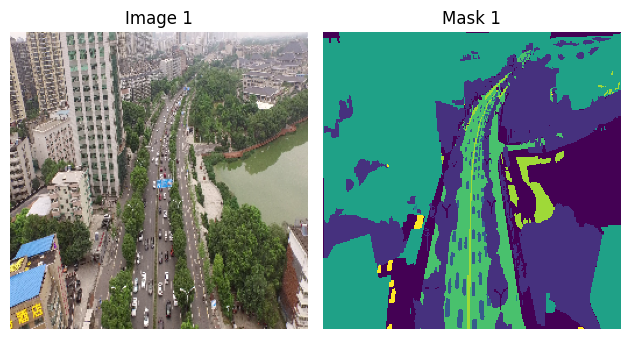

87.72593688964844 0 236


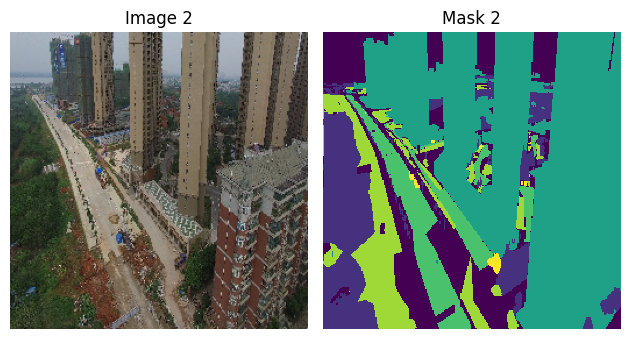

160.11233520507812 0 255


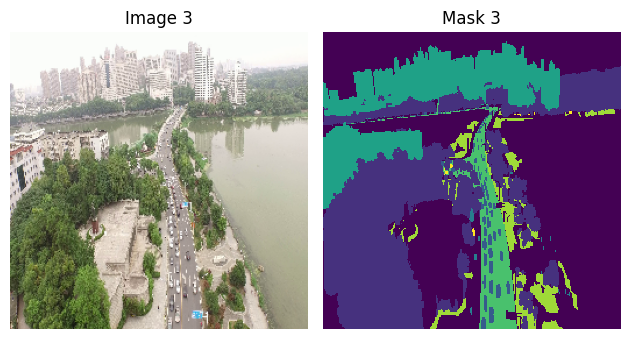

101.32565816243489 0 255


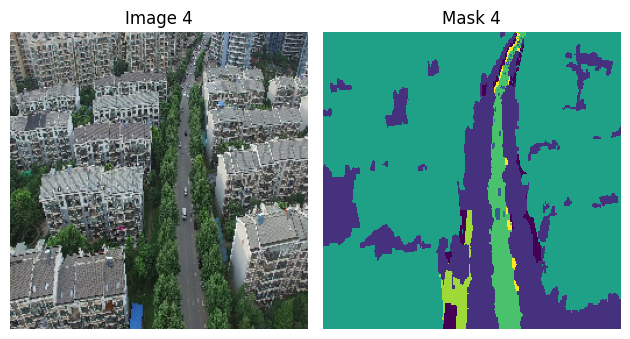

In [49]:
for k in range(4):
        img_to_show_normalized = image[k].cpu() # Get a single image tensor and move to CPU

        # Denormalize the image tensor (reverse the normalization step)
        # NORM_MEAN and NORM_STD should be reshaped to (3, 1, 1) for broadcasting across channels
        img_to_show_denormalized = img_to_show_normalized * NORM_STD.view(3, 1, 1) + NORM_MEAN.view(3, 1, 1)

        # Clamp values to [0, 1] range to ensure valid display by matplotlib
        img_to_show_clamped = torch.clamp(img_to_show_denormalized, 0, 1)

        # Permute from (C, H, W) to (H, W, C) for matplotlib and convert to numpy
        # Optionally scale to [0, 255] and cast to uint8 for typical image viewing
        img_to_show_np = (img_to_show_clamped.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        print(img_to_show_np.mean(), img_to_show_np.min(), img_to_show_np.max())
        plt.subplot(121)
        plt.imshow(img_to_show_np)
        plt.title(f"Image {k+1}")
        plt.axis('off')

        # Process mask for display
        mask_to_show_np = mask[k].cpu().numpy() # Move to CPU and convert to numpy
        plt.subplot(122)
        # Use a colormap for masks to differentiate classes, and 'nearest' interpolation
        plt.imshow(mask_to_show_np, cmap='viridis', interpolation='nearest')
        plt.title(f"Mask {k+1}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### **Data Generator; the alternative version**

In this version the normalization process is performed using albumentation

In [50]:
def get_transforms(phase, height, width, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std),
            Resize(height, width), # Correctly pass height and width
            ToTensorV2()
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [52]:
import cv2
import numpy as np
import os

from pathlib import Path


class Preprocessor():
    COLOR_MAP = {(np.uint8(0), np.uint8(0), np.uint8(0)): 0,  # Background
                 (np.uint8(0), np.uint8(128), np.uint8(0)): 1,  # Tree
                 (np.uint8(64), np.uint8(0), np.uint8(128)): 2,  # Moving car
                 (np.uint8(64), np.uint8(64), np.uint8(0)): 3,  # Human
                 (np.uint8(128), np.uint8(0), np.uint8(0)): 4,  # Building
                 (np.uint8(128), np.uint8(64), np.uint8(128)): 5,  # Road
                 (np.uint8(128), np.uint8(128), np.uint8(0)): 6,  # Low vegetation
                 (np.uint8(192), np.uint8(0), np.uint8(192)): 7}  # Static car

    def __init__(self,
                 image_path: Path,
                 normalize_flag: bool = False,
                 mean: tuple = None,
                 std: tuple = None):
        self.image_path = image_path
        self.normalize_flag = normalize_flag
        self.mean = mean
        self.std = std

    def preprocess_image(self):
        image = self._read_image(self.image_path)
        if self.normalize_flag:
            image = self._normalize(image)
        return image

    def preprocess_mask(self):
        mask_path = self.image_path.replace('Images', 'Labels')
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Label file not found for: {mask_path}")
        mask = self._read_image(mask_path)
        mask = self._rgb_to_gray(mask)
        return mask

    @staticmethod
    def _read_image(file_path):
        image = cv2.imread(file_path)  # Loads as BGR, numpy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image = image.astype(float)
        return image

    def _normalize(self, image):
        """
        Standard normalization is applied using the formula:
        img = (img - mean * max_pixel_value) / (std * max_pixel_value).
        """
        image = image/255.
        mean = np.array(self.mean, dtype=np.float32)
        std = np.array(self.std, dtype=np.float32)
        image = (image - mean) / std
        # image = (image - mean * 255) / (std * 255)
        return image

    def _rgb_to_gray(cls, rgb_label_array):
        """
        Converts a 3-channel RGB label image to a single-channel class ID mask.

        Args:
            rgb_label_image (np.ndarray): The 3-channel (H, W, 3) RGB label image.

        Returns:
            np.ndarray: A single-channel (H, W) mask with integer class IDs.
        """
        rgb_pixels_tuples = [tuple(p) for p in rgb_label_array.reshape(-1, 3)]
        gray_mask = [cls.COLOR_MAP[rgb_pixels_tuples[i]] for i in range(len(rgb_pixels_tuples))]
        gray_mask = np.array(gray_mask, dtype=np.uint8).reshape(rgb_label_array.shape[0],
                                                                rgb_label_array.shape[1])
        return gray_mask


In [67]:
from torch.utils.data import Dataset, DataLoader

class SemanticSegmentationDataset(Dataset):
    CLASSES = [
        "Background",
        "Tree",
        "Moving car",
        "Human",
        "Building",
        "Road",
        "Low vegetation",
        "Static car",
    ]
    def __init__(self,
                 data_paths: Path,
                 phase: str,
                 height=256,
                 width=256,
                 mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225)):
        self.data_paths = data_paths
        self.transforms = get_transforms(phase, height, width,mean, std)
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.data_paths[idx]
        preprocessor = Preprocessor(image_path=image_path,
                                    normalize_flag=False)
        image = preprocessor.preprocess_image()
        mask = preprocessor.preprocess_mask()
        # Removed: mask = mask.astype(float) to keep mask as integer type

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask'].long() # Explicitly convert mask to LongTensor for CrossEntropyLoss

        return image, mask


class DataGenerator:
    def __init__(self,
                 dir: Path,
                 phase: str,
                 batch_size: int,
                 shuffle: bool):
        self.dir = dir
        self.phase = phase
        self.batch_size = batch_size
        self.shuffle = shuffle

    def load_data(self):
        paths = self._create_data_paths()
        dataset = SemanticSegmentationDataset(paths, phase=self.phase)
        dataloader = DataLoader(dataset,
                                batch_size=self.batch_size,
                                shuffle=self.shuffle,
                                num_workers=os.cpu_count())
        return dataloader

    def _create_data_paths(self):
        data_paths = []
        for seq in os.listdir(self.dir):
            seq_dir_images = os.path.join(self.dir, seq, 'Images')
            for files in os.listdir(seq_dir_images):
                if files.endswith('.jpg') or files.endswith('.png'):
                    file_path = os.path.join(seq_dir_images, files)
                    data_paths.append(file_path)
        return data_paths


In [56]:
data_generator = DataGenerator(train_dir, "test", 8, True).load_data()

In [57]:
print(len(data_generator))
# Define mean and std tensors matching those used in get_transforms
# Assuming these are the values used for normalization in get_transforms
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

for batch in data_generator:
    image, mask = batch
    print(image.shape)
    print(mask.shape)
    print(image[0].shape)
    print(image[0].dtype)
    print(np.unique(mask))
    print(image.mean(), image.min(), image.max())
    break

25
torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])
torch.Size([3, 256, 256])
torch.float32
[0 1 2 3 4 5 6 7]
tensor(0.0519) tensor(-2.1179) tensor(2.6400)


0.4447776 0.0 1.0


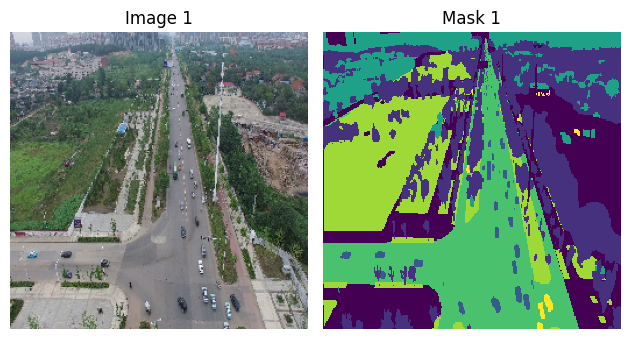

0.46166226 0.0 1.0


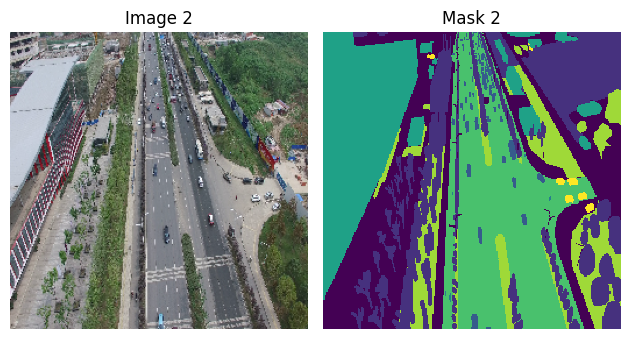

0.4383347 0.0 1.0


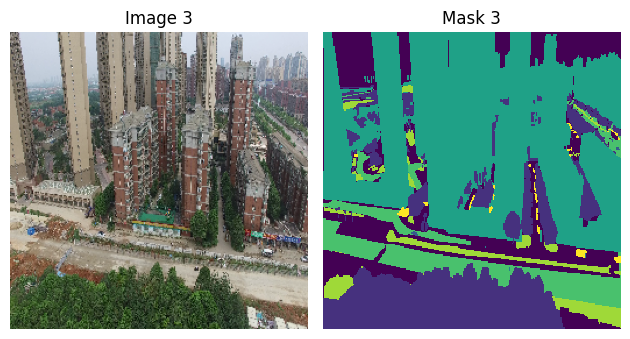

0.41773415 0.0 1.0


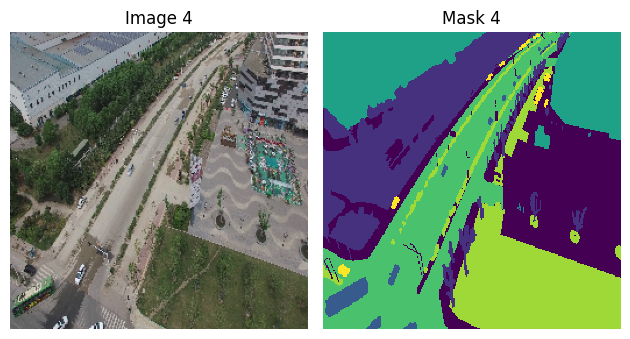

In [59]:
for k in range(4):
        img_to_show_normalized = image[k].cpu() # Get a single image tensor and move to CPU

        # Denormalize the image tensor (reverse the normalization step)
        # NORM_MEAN and NORM_STD should be reshaped to (3, 1, 1) for broadcasting across channels
        img_to_show_denormalized = img_to_show_normalized * NORM_STD.view(3, 1, 1) + NORM_MEAN.view(3, 1, 1)

        # # Clamp values to [0, 1] range to ensure valid display by matplotlib
        img_to_show_clamped = torch.clamp(img_to_show_denormalized, 0, 1)

        # Permute from (C, H, W) to (H, W, C) for matplotlib and convert to numpy
        # Optionally scale to [0, 255] and cast to uint8 for typical image viewing
        # img_to_show_np = (img_to_show_clamped.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        img_to_show_np = img_to_show_clamped.permute(1, 2, 0).numpy()
        print(img_to_show_np.mean(), img_to_show_np.min(), img_to_show_np.max())
        plt.subplot(121)
        plt.imshow(img_to_show_np)
        plt.title(f"Image {k+1}")
        plt.axis('off')

        # Process mask for display
        mask_to_show_np = mask[k].cpu().numpy() # Move to CPU and convert to numpy
        plt.subplot(122)
        # Use a colormap for masks to differentiate classes, and 'nearest' interpolation
        plt.imshow(mask_to_show_np, cmap='viridis', interpolation='nearest')
        plt.title(f"Mask {k+1}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [68]:
train_generator = DataGenerator(train_dir, phase="train", batch_size=8, shuffle=True).load_data()
val_generator = DataGenerator(val_dir, phase="val", batch_size=len(os.listdir(val_dir)), shuffle=False).load_data()
test_generator = DataGenerator(test_dir, phase="test", batch_size=len(os.listdir(test_dir)), shuffle=False).load_data()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Model Building

In [ ]:
# !git clone https://github.com/qubvel-org/segmentation_models.pytorch.git

In [61]:
!pip install segmentation_models_pytorch > /dev/null -q

In [62]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [64]:
# Some training hyperparameters
EPOCHS = 20
T_MAX = EPOCHS * len(train_generator)
# Always include the background as a class
OUT_CLASSES = 8

In [65]:
import segmentation_models_pytorch as smp

activation = 'sigmoid' if OUT_CLASSES == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,                     # model output classes (number of classes in your dataset)
    activation=activation
).to(device)


print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Training

## Loss and Optimizer
- Loss = BCE + Dice_loss
- Optimizer = Adam with initial_lr = 1e-3
- lr_scheduler with CosineAnnealingLR for lr decay

In [66]:
# Loss function for multi-class segmentation
# loss_function = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-3,weight_decay=0)

epoch_num = 25
val_interval = 1

steps = epoch_num#int(len(train_slices)/batch_size)+1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

## Training

In [ ]:
for batch_data in train_dataloader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        print(f'shapes = {inputs.shape} , {labels.shape}')
# model()

shapes = torch.Size([8, 3, 256, 256]) , torch.Size([8, 256, 256])
shapes = torch.Size([8, 3, 256, 256]) , torch.Size([8, 256, 256])


In [ ]:
preds = model(inputs)
preds.shape

torch.Size([8, 8, 256, 256])

In [ ]:
# logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = preds.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]
pr_masks.shape, pr_masks.min(), pr_masks.max()

(torch.Size([8, 256, 256]), tensor(0), tensor(7))

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
checkpoint_path = "/content/drive/MyDrive/epoch=3-step=100 (1)_468.ckpt" # Replace with the actual path to your saved model

# Set the starting epoch if resuming training
start_epoch = 0 # Default if starting from scratch, will be updated if checkpoint is loaded

# Initialize best_metric for resume functionality
# If you save the best_metric along with the model, load it here
# Otherwise, initialize it to a low value so any new improvement is captured
resumed_best_metric = -1.0 # Or the value saved with your checkpoint

try:
    # Load the entire checkpoint dictionary
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Check if the model's state_dict is nested within a key (common in PyTorch Lightning)
    if 'state_dict' in checkpoint:
        # Extract the model's state_dict
        model_state_dict = checkpoint['state_dict']

        # Filter out unwanted keys and remove 'model.' prefix
        filtered_state_dict = {}
        for k, v in model_state_dict.items():
            # Remove 'model.' prefix if present
            key = k.replace('model.', '')
            # Only include keys that are part of the Unet model's architecture
            # (encoder, decoder, segmentation_head)
            if key.startswith(('encoder', 'decoder', 'segmentation_head')):
                filtered_state_dict[key] = v
            else:
                print(f"Skipping unexpected key in checkpoint: {k}")

        model.load_state_dict(filtered_state_dict)
        print(f"Model state_dict loaded successfully from '{checkpoint_path}' (extracted from 'state_dict' key)")

        # Also load other training parameters if available in the checkpoint
        if 'epoch' in checkpoint: # Assuming 'epoch' key exists in the checkpoint
            start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
            print(f"Resuming training from epoch {start_epoch}")
        if 'callbacks' in checkpoint and 'best_model_score' in checkpoint['callbacks']:
            # Adjust this based on how your specific checkpoint stores best_metric
            resumed_best_metric = checkpoint['callbacks']['best_model_score']
            print(f"Resumed with best metric: {resumed_best_metric:.4f}")

    else:
        # If the state_dict is not nested, try to load it directly (less common for full checkpoints)
        # This path might still encounter issues if 'std'/'mean' are top-level and not filtered.
        print("Checkpoint does not contain 'state_dict' key. Attempting direct load.")
        model.load_state_dict(checkpoint)
        print(f"Model state_dict loaded successfully from '{checkpoint_path}'")

    # Update the `best_metric` variable for the training loop
    best_metric = resumed_best_metric

except FileNotFoundError:
    print(f"No checkpoint found at {checkpoint_path}. Starting training from scratch.")
except Exception as e:
    print(f"Error loading model: {e}. Starting training from scratch.")

# To truly resume, you would need to modify the training loop (cell WLUuxPdtFKC1) as follows:
# 1. Ensure this code block is executed *before* the `for epoch in range(...)` loop.
# 2. Change `for epoch in range(epoch_num):` to `for epoch in range(start_epoch, epoch_num):`.
# 3. Ensure `best_metric` in the training loop is initialized with `resumed_best_metric` from this block.

Skipping unexpected key in checkpoint: std
Skipping unexpected key in checkpoint: mean
Model state_dict loaded successfully from '/content/drive/MyDrive/epoch=3-step=100 (1)_468.ckpt' (extracted from 'state_dict' key)
Resuming training from epoch 4


In [77]:
import sys
from tqdm import tqdm


best_metric = -1 # Initialize with a value that will be easily surpassed
best_metric_epoch = -1
epoch_loss_values = []
metric_values = [] # This will store average IoU for each epoch

for epoch in tqdm(range(start_epoch, epoch_num)):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    epoch_len = len(train_generator)
    step = 0
    for i_batch, batch_data in enumerate(train_generator):

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs) # Logits (Batch, Classes, H, W)
        loss = loss_function(outputs, labels) # CrossEntropyLoss expects logits and Long labels
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_iou_scores = []
            for val_data_batch in val_generator:
                val_images, val_labels = val_data_batch[0].to(device), val_data_batch[1].to(device)
                val_outputs = model(val_images) # Logits (Batch, Classes, H, W)

                # Convert logits to predicted class labels
                pr_masks = val_outputs.softmax(dim=1).argmax(dim=1)  # Shape: [batch_size, H, W]

                # Calculate TP, FP, FN, TN for multiclass
                # The `get_stats` function computes a confusion matrix for each image/batch
                # and returns summed tp, fp, fn, tn.
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pr_masks,  # Predicted mask (argmaxed)
                    val_labels, # Ground truth mask
                    mode='multiclass',
                    num_classes=OUT_CLASSES, # Number of classes (including background)
                    ignore_index=None, # Set an index if you want to ignore a specific class
                )

                # Calculate IoU score from the stats
                # The `reduction` parameter applies to how the IoU is averaged across classes and/or images.
                # 'micro' means sum TP, FP, FN across classes and then calculate IoU.
                batch_iou = smp.metrics.iou_score(
                    tp, fp, fn, tn,
                    reduction='micro'
                )
                val_iou_scores.append(batch_iou.item())

            avg_val_iou = np.mean(val_iou_scores)
            metric_values.append(avg_val_iou) # Store the average IoU for this epoch

            if avg_val_iou > best_metric:
                best_metric = avg_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f'best_model_epoch{epoch}_{avg_val_iou:.4f}.pth')
                print('###### Congratulations ###### saved new best metric model')
            print(f"current epoch: {epoch + 1} current IoU: {avg_val_iou:.4f}"
                  f" best IoU: {best_metric:.4f} at epoch: {best_metric_epoch}")
        scheduler.step()
        # Use get_last_lr() for PyTorch 1.4+ and later versions
        print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        print('The learning rate updated to :',scheduler.get_last_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

  0%|          | 0/21 [00:00<?, ?it/s]

----------
epoch 5/25


  5%|▍         | 1/21 [06:03<2:01:14, 363.75s/it]

###### Congratulations ###### saved new best metric model
current epoch: 5 current IoU: 0.0912 best IoU: 0.0912 at epoch: 5

 ###### epoch 5 average loss: 1.7444
The learning rate updated to : 0.0009045084971874737
----------
epoch 6/25


 10%|▉         | 2/21 [12:06<1:54:56, 362.96s/it]

###### Congratulations ###### saved new best metric model
current epoch: 6 current IoU: 0.1027 best IoU: 0.1027 at epoch: 6

 ###### epoch 6 average loss: 1.7237
The learning rate updated to : 0.0008644843137107057
----------
epoch 7/25


 14%|█▍        | 3/21 [18:06<1:48:32, 361.82s/it]

###### Congratulations ###### saved new best metric model
current epoch: 7 current IoU: 0.1169 best IoU: 0.1169 at epoch: 7

 ###### epoch 7 average loss: 1.7049
The learning rate updated to : 0.0008187119948743448
----------
epoch 8/25


 19%|█▉        | 4/21 [24:07<1:42:25, 361.52s/it]

###### Congratulations ###### saved new best metric model
current epoch: 8 current IoU: 0.1239 best IoU: 0.1239 at epoch: 8

 ###### epoch 8 average loss: 1.6864
The learning rate updated to : 0.0007679133974894982
----------
epoch 9/25


 19%|█▉        | 4/21 [25:51<1:49:53, 387.86s/it]


KeyboardInterrupt: 

In [ ]:
print(outputs.shape)

torch.Size([8, 8, 256, 256])


# Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=True)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     valid_dataset_iou     │    0.1699063926935196     │
│    valid_per_image_iou    │    0.17548923194408417    │
└───────────────────────────┴───────────────────────────┘

[{'valid_per_image_iou': 0.17548923194408417, 'valid_dataset_iou': 0.1699063926935196}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=True)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\windows\computer_vision\image_seg\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.744439959526062, 'test_dataset_iou': 0.7414864301681519}]


In [ ]:
from google.colab import files
files.download('/content/lightning_logs/version_0/checkpoints/epoch=0-step=25.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Result visualization

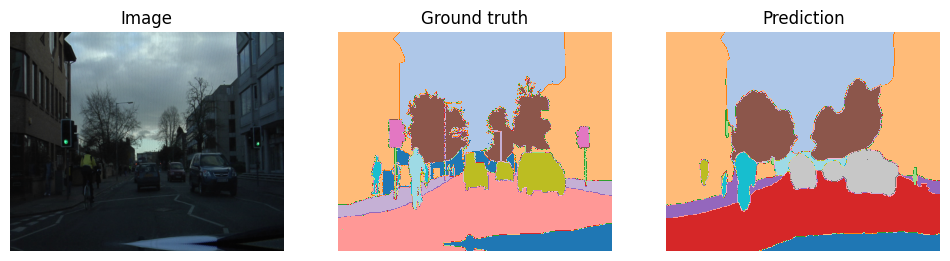

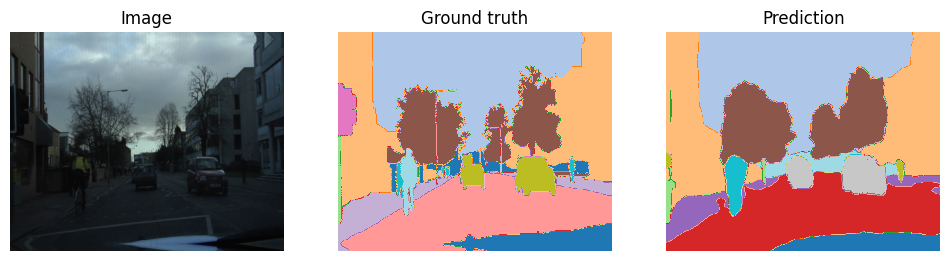

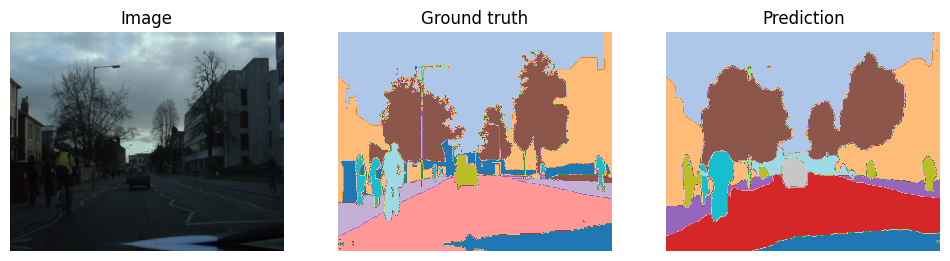

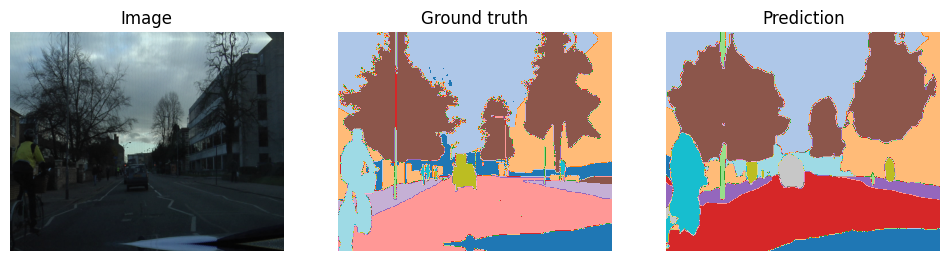

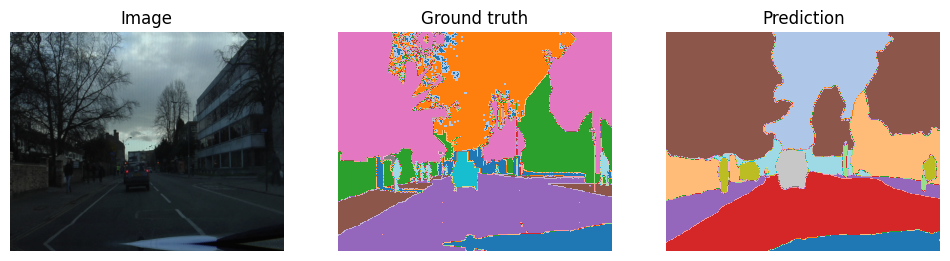

In [ ]:
import numpy as np

# Fetch a batch from the test loader
images, masks = next(iter(test_loader))

# Switch the model to evaluation mode
with torch.inference_mode():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break